In [ ]:
#Run once per session
%load_ext autoreload
%autoreload 2
!pip install -q fastai==2.0.14

# ITL fast.ai model

In [2]:
from fastai.vision.all import *

In [3]:
VERSION=8
ITL_DS_NAME = f'itl_dataset_v{VERSION}.zip'
ITL_DS_URL =  f'http://students.mimuw.edu.pl/~mt406390/machine_learning/' + ITL_DS_NAME
!wget $ITL_DS_URL
!unzip -qq $ITL_DS_NAME -d data/
path = Path('data')

--2020-10-03 13:44:00--  http://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v8.zip
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v8.zip [following]
--2020-10-03 13:44:00--  https://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v8.zip
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102555166 (98M) [application/zip]
Saving to: ‘itl_dataset_v8.zip’

itl_dataset_v8.zip  100%[===================>]  97.80M  16.9MB/s    in 5.7s    

2020-10-03 13:44:06 (17.3 MB/s) - ‘itl_dataset_v8.zip’ saved [102555166/102555166]



In [13]:
path.ls()

(#8) [Path('data/output_black'),Path('data/output_color'),Path('data/operators.txt'),Path('data/output_bbox'),Path('data/output_proper'),Path('data/annotations.json'),Path('data/itl_labels.txt'),Path('data/config')]

In [38]:
annots = json.load(path / 'annotations.json')
# FIXME (17 bboxes missing)
annots = list(filter(lambda x: len(x['exprs']) > 0, annots))

In [15]:
images = list(x['name'] for x in annots if len(x['exprs']) > 0)
print(len(images))
images[0]

6127


'eq0.png'

Next, we want to be able to quickly look up a corresponding image to it's label. We'll use a dictionary

In [16]:
img2bbox = dict(zip(images, annots))

Let's check the first item

Great! Now let's build our `DataBlock`. We'll have two outputs, the bounding box itself and a label, with one input. For our `y`'s, we'll define some `getters`. The first of which will be `noop`, as we don't care about our initial image, and then we'll grab our label and bbox coordinates (we'll also define our `get_items`)

In [17]:
def bbox_to_fastai(box):
    x, y, dx, dy = box
    return [x, y, x + dx, y + dy]

getters = [lambda o: path/'output_proper'/o, lambda o: list(map(bbox_to_fastai, img2bbox[o]['exprs'])),
           lambda o: len(img2bbox[o]['exprs']) * [img2bbox[o]['op']]
           ]


# getters_cat = [lambda o: path/'output_proper'/o, lambda o: img2bbox[o]['op']]

For our transforms, we'll use some of the ones we defined earlier

In [18]:
item_tfms = []
batch_tfms = [Zoom(0.8, 1.2), Warp(0.15), Saturation(max_lighting=0.5)]

Why do we need a custom `get_images`? Because we want our **images** that came back to us, not the entire folder

In [19]:
def get_train_imgs(noop):  return images

We'll now make our `DataBlock`. We want to adjust `n_inp` as we expect two outputs

In [20]:
pascal = DataBlock(blocks=(ImageBlock(cls=PILImageBW), BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs, 
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

# pascal = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
#                  splitter=RandomSplitter(),
#                  get_items=get_train_imgs, 
#                  getters=getters_cat,
#                  item_tfms=item_tfms,
#                  batch_tfms=batch_tfms,
#                  n_inp=1)

In [21]:
BS = 32
dls = pascal.dataloaders(path/'train', bs=BS)
dls.c = len(set(x['op'] for x in annots))

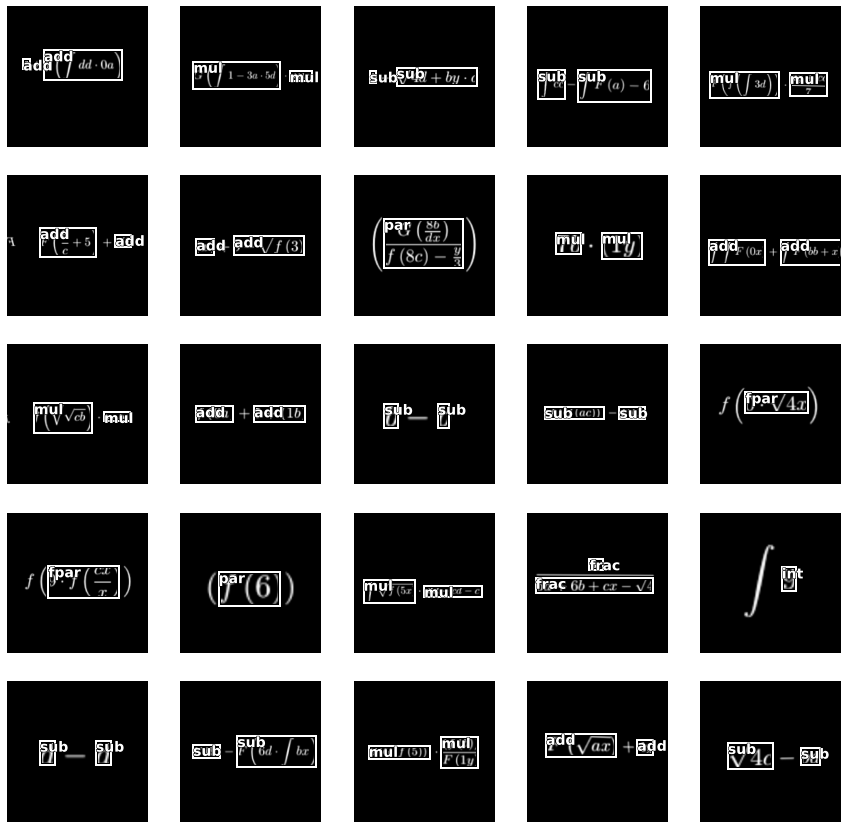

In [22]:
dls.show_batch(max_n=25)

# ITL model

In [23]:
POINTS_PER_BBOX = 4
N_BBOXES = 2
BBOXES = N_BBOXES * POINTS_PER_BBOX
CATS = dls.c
OUT = CATS + BBOXES

In [24]:
head = nn.Sequential(
    nn.Conv2d(512, 128, 3, 2),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, OUT, 3, 1),
    nn.BatchNorm2d(OUT),
    nn.Flatten()
)

cfg = cnn_config(n_in=1, custom_head=head)

In [29]:
from torchvision.ops import box_iou

from pdb import set_trace


def itl_loss(pred, target_bboxes, target_cat):
    target_bboxes_scaled = (1 + target_bboxes) / 2
    bboxes_preds = torch.sigmoid(pred[..., CATS:]).view((-1, N_BBOXES, POINTS_PER_BBOX))
    mask = (target_cat > 0)

    box_loss = F.mse_loss(bboxes_preds[mask], target_bboxes_scaled[mask], reduction='sum')
    ce_loss = F.cross_entropy(pred[..., :CATS], target_cat[..., 0] - 1)
    return ce_loss + box_loss

def ops_accuracy(pred, target_bboxes, target_cat):
    return accuracy(pred[..., :CATS], target_cat[..., 0] - 1)
    
def boxes_iou(pred, target_bboxes, target_cat):
    bboxes_preds = torch.sigmoid(pred[..., CATS:]).view((-1, N_BBOXES, POINTS_PER_BBOX))
    bboxes_preds = (2 * bboxes_preds) - 1

    mask = (target_cat > 0)
    x, y = bboxes_preds[mask], target_bboxes[mask]
    ious = torch.diagonal(box_iou(x, y))
    return ious.mean()

In [45]:
learn = cnn_learner(dls, resnet18, loss_func=itl_loss, pretrained=False, config=cfg,
                    metrics=[ops_accuracy, boxes_iou])

learn.fit_one_cycle(25, lr_max=8e-4)

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,4.928980,3.727499,0.465306,0.376458,00:23
1,3.336650,2.369176,0.577959,0.450541,00:23
2,2.312775,2.014090,0.630204,0.466701,00:24
3,1.768930,1.842658,0.599184,0.497371,00:24
4,1.364169,2.158223,0.629388,0.455181,00:24
5,1.140778,6.226180,0.360000,0.307093,00:24
6,0.928137,2.056102,0.711020,0.409015,00:24
7,0.856492,14.949759,0.183673,0.170506,00:24
8,0.735739,1.286780,0.782857,0.603460,00:23
9,0.702864,4.148093,0.503673,0.420147,00:24
